
# 0. Import Libraries


In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# 1. Load and Explore Dataset

In [210]:
df = pd.read_csv("US.csv")  # Update path if needed
print("Dataset Overview:")
print(df.describe())
print(df.info())  # Dataset metadata
print(df.head())  # Initial data preview

Dataset Overview:
               accX          accY          accZ         chord           arc  \
count  2.555340e+06  2.555340e+06  2.555340e+06  2.555340e+06  2.544676e+06   
mean  -1.796188e+00  5.106288e+00 -1.317733e+00  1.148565e-01  1.022259e-01   
std    3.884663e+00  6.110880e+00  3.386427e+00  3.278833e-01  1.792797e-01   
min   -1.865000e+01 -1.961000e+01 -1.961000e+01  0.000000e+00  0.000000e+00   
25%   -3.940000e+00  4.130000e+00 -4.190000e+00  4.582576e-02  4.582977e-02   
50%   -2.870000e+00  8.340000e+00 -8.900000e-01  6.557439e-02  6.558614e-02   
75%    3.000000e-02  9.020000e+00  1.020000e+00  9.433981e-02  9.384275e-02   
max    1.961000e+01  1.961000e+01  1.961000e+01  4.938829e+01  3.117097e+00   

        orientation            ir          full           iaq     staticIaq  \
count  2.555340e+06  2.555340e+06  2.555340e+06  2.555340e+06  2.555340e+06   
mean   2.673342e+00  1.691852e+02  5.954386e+02  8.555708e+01  6.874903e+01   
std    1.522494e+00  6.973241e+02

# 2. Data Preprocessing

In [211]:
print(df.columns)

# Ensure 'Real_time' column exists
if 'Real_time' in df.columns:
    df['Real_time'] = pd.to_datetime(df['Real_time'])  # Convert to datetime for temporal analysis
else:
    raise KeyError("Column 'Real_time' does not exist in the DataFrame.")

df.drop(columns=['RowID'], inplace=True, errors="ignore")  # Drop RowID if exists

# Encode categorical features
categorical_features = ['orientation_cat', 'sound_cat']
for feature in categorical_features:
    df[feature] = LabelEncoder().fit_transform(df[feature])

# Aggregate sensor data over 15-minute windows
df.set_index('Real_time', inplace=True)
agg_df = df.resample('15min').agg({
    'accX': ['mean', 'median'],
    'accY': ['mean', 'median'],
    'accZ': ['mean', 'median'],
    'chord': 'sum',
    'arc': 'sum',
    'iaq': ['mean', 'median'],
    'temperature': ['mean', 'median'],
    'humidity': ['mean', 'median'],
    'audioLevel': ['mean', 'median'],
    'pressure': ['mean', 'median'],
    'co2Equivalent': ['mean', 'median'],
    'gasResistance': ['mean', 'median'],
    'breathVocEquivalent': ['mean', 'median'],
    'orientation_cat': 'max',
    'sound_cat': 'max',
    'Modality_cat': lambda x: list(x)
})
agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
agg_df.reset_index(inplace=True)

# Filter rows with non-empty target lists (multi-label classification)
agg_df = agg_df[agg_df['Modality_cat_<lambda>'].apply(len) > 0]

# Select features and target
features = [col for col in agg_df.columns if col not in ['Modality_cat_<lambda>', 'Real_time']]
X = agg_df[features]
y = agg_df['Modality_cat_<lambda>']

# Impute missing numeric values
numeric_features = X.select_dtypes(include=[np.float64]).columns
imputer = SimpleImputer(strategy='mean')
X.loc[:, numeric_features] = imputer.fit_transform(X[numeric_features])

# Encode multi-label targets
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

Index(['RowID', 'Real_time', 'accX', 'accY', 'accZ', 'chord', 'arc',
       'orientation', 'orientation_cat', 'ir', 'full', 'iaq', 'staticIaq',
       'pressure', 'gasResistance', 'temperature', 'humidity', 'co2Equivalent',
       'breathVocEquivalent', 'audioLevel', 'sound_cat', 'Modality_cat',
       'Modality'],
      dtype='object')


# 3. Exploratory Data Analysis (EDA)

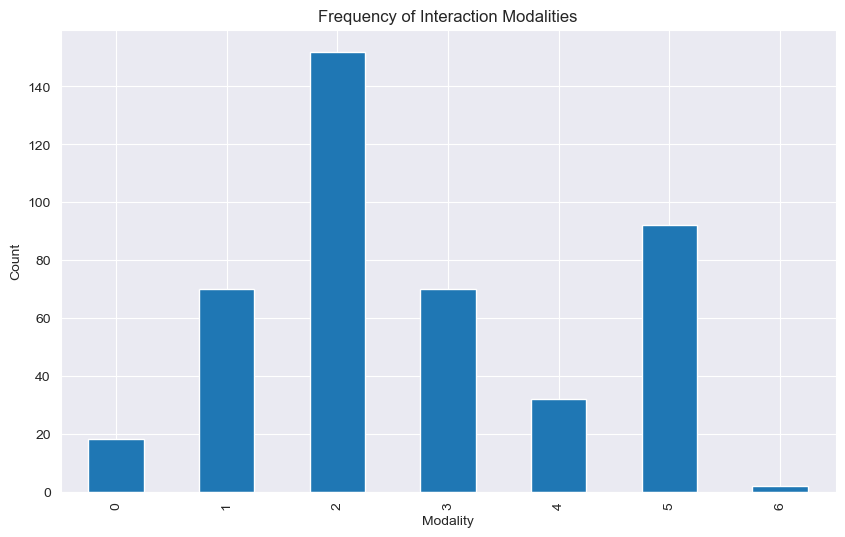

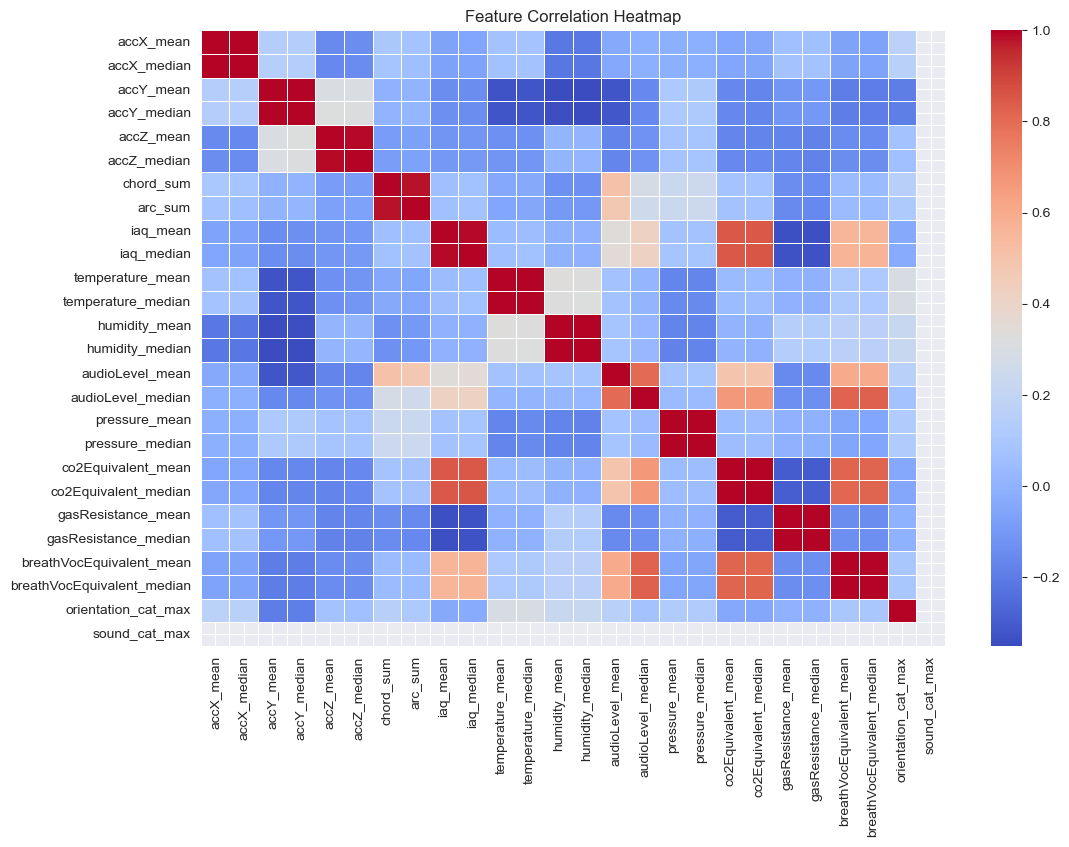

In [213]:
plt.figure(figsize=(10, 6))
y_mlb_df = pd.DataFrame(y, columns=mlb.classes_)
y_mlb_df.sum().plot(kind='bar')
plt.title("Frequency of Interaction Modalities")
plt.xlabel("Modality")
plt.ylabel("Count")
plt.show()

# Correlation analysis
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# 4. RandomForestClassifier with Hyperparameter Tuning

In [228]:
param_grid_rf = {
    'estimator__n_estimators': [50, 100, 200, 300, 400],
    'estimator__max_depth': [10, 20, 30, 40, 50, None],
    'estimator__min_samples_split': [2, 5, 10, 15],
    'estimator__min_samples_leaf': [1, 2, 4, 6],
    'estimator__max_features': ['sqrt', 'log2', None],
    'estimator__bootstrap': [True, False]
}

# Initialize the RandomForest model
rf_model = MultiOutputClassifier(RandomForestClassifier(random_state=42, n_jobs=-1))

# Perform RandomizedSearchCV for hyperparameter tuning
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_grid_rf, n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search_rf.fit(X_train, y_train)

# Get the best parameters from the search
best_params_rf = {param.replace('estimator__', ''): value for param, value in random_search_rf.best_params_.items()}

# Initialize and train the RandomForest model with the best parameters
best_rf_model = MultiOutputClassifier(RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1))
best_rf_model.fit(X_train, y_train)

# Predict using the trained model
y_pred_rf = best_rf_model.predict(X_test)
y_pred_rf

Fitting 5 folds for each of 50 candidates, totalling 250 fits


array([[0, 0, 1, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0],
       [0, 1, 1, 0, 0, 1, 0],
       [1, 1, 1, 0, 1, 0, 0],
       [0, 1, 1, 0, 1, 1, 0],
       [0, 0, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 0],
       [1, 1, 1, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 1, 0],
       [0, 0, 1, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 1, 0],
       [1, 1, 1, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 1, 1, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0],
       [0,

# 5. XGBClassifier with Hyperparameter Tuning

In [233]:
# Define the enhanced parameter grid for XGBoost
param_grid_xgb = {
    'estimator__n_estimators': [100, 200, 300, 400],
    'estimator__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'estimator__max_depth': [3, 4, 5, 6, 7],
    'estimator__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'estimator__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'estimator__gamma': [0, 0.1, 0.2, 0.3],
    'estimator__min_child_weight': [1, 2, 3, 4]
}

# Initialize the XGBoost model
xgb_model = MultiOutputClassifier(XGBClassifier(random_state=42, tree_method='hist', eval_metric='logloss'))

# Perform RandomizedSearchCV for hyperparameter tuning
random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_grid_xgb, n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search_xgb.fit(X_train, y_train)

# Get the best parameters from the search
best_params_xgb = random_search_xgb.best_params_
best_params_xgb = {param.replace('estimator__', ''): value for param, value in best_params_xgb.items()}

# Initialize and train the XGBoost model with the best parameters
best_xgb_model = MultiOutputClassifier(XGBClassifier(**best_params_xgb, random_state=42, tree_method='hist', eval_metric='logloss'))
best_xgb_model.fit(X_train, y_train)

# Predict using the trained model
y_pred_xgb = best_xgb_model.predict(X_test)
y_pred_xgb

Fitting 5 folds for each of 50 candidates, totalling 250 fits


array([[0, 0, 1, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0],
       [0, 1, 1, 0, 0, 1, 0],
       [1, 1, 1, 0, 1, 0, 0],
       [0, 1, 1, 0, 1, 1, 0],
       [0, 0, 1, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 0],
       [0, 1, 1, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 1, 0],
       [0, 1, 1, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0],
       [0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 1, 1, 0, 0, 1, 0],
       [0, 1, 1, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0],
       [0,

# 6. LightGBM Model

In [ ]:
# Define the parameter grid for LightGBM
param_grid_lgbm = {
    'estimator__max_depth': [10, 20, 30, -1],  # No limit on depth
    'estimator__num_leaves': [31, 50, 70, 100],  # Increase the number of leaves
    'estimator__min_data_in_leaf': [10, 20, 30, 40],  # Reduce the minimum data in leaf
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__n_estimators': [100, 200, 300],
    'estimator__subsample': [0.8, 0.9, 1.0],
    'estimator__colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the LightGBM model
lgbm_model = MultiOutputClassifier(LGBMClassifier(random_state=42))

# Perform RandomizedSearchCV for hyperparameter tuning
random_search_lgbm = RandomizedSearchCV(lgbm_model, param_distributions=param_grid_lgbm, n_iter=20, cv=5, n_jobs=-1,
                                        verbose=2, random_state=42)
random_search_lgbm.fit(X_train, y_train)

# Get the best parameters from the search
best_params_lgbm = random_search_lgbm.best_params_
best_params_lgbm = {param.replace('estimator__', ''): value for param, value in best_params_lgbm.items()}

# Initialize and train the LightGBM model with the best parameters
best_lgbm_model = MultiOutputClassifier(LGBMClassifier(**best_params_lgbm, random_state=42))
best_lgbm_model.fit(X_train, y_train)

# Predict using the trained model
y_pred_lgbm = best_lgbm_model.predict(X_test)

# 7. Model Evaluation


Random Forest Performance:
Accuracy: 0.55
F1 Score: 0.838148013123434
AUC-ROC: 0.8288497217068646
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.93      0.78      0.85        18
           2       0.88      1.00      0.94        29
           3       0.82      0.75      0.78        12
           4       0.67      0.50      0.57         8
           5       0.75      0.95      0.84        19
           6       0.00      0.00      0.00         1

   micro avg       0.84      0.86      0.85        91
   macro avg       0.72      0.71      0.71        91
weighted avg       0.83      0.86      0.84        91
 samples avg       0.85      0.85      0.84        91



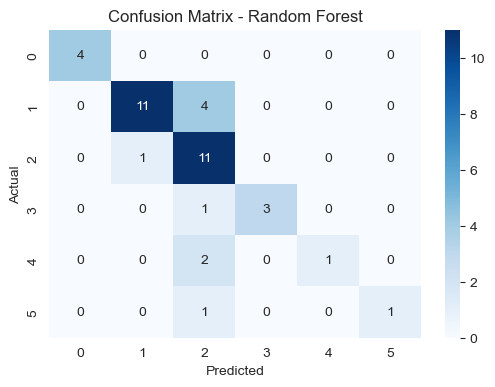


XGBoost Performance:
Accuracy: 0.55
F1 Score: 0.8194588726150188
AUC-ROC: 0.8043741972313402
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.89      0.89      0.89        18
           2       0.85      1.00      0.92        29
           3       0.80      0.67      0.73        12
           4       0.67      0.50      0.57         8
           5       0.75      0.95      0.84        19
           6       0.00      0.00      0.00         1

   micro avg       0.82      0.85      0.83        91
   macro avg       0.71      0.64      0.66        91
weighted avg       0.81      0.85      0.82        91
 samples avg       0.84      0.85      0.83        91



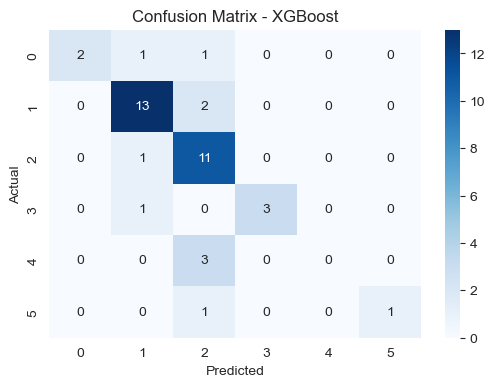


LightGBM Performance:
Accuracy: 0.625
F1 Score: 0.8382728382728382
AUC-ROC: 0.8203344274772847
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.89      0.89      0.89        18
           2       0.85      1.00      0.92        29
           3       0.80      0.67      0.73        12
           4       0.67      0.50      0.57         8
           5       0.78      0.95      0.86        19
           6       0.00      0.00      0.00         1

   micro avg       0.83      0.87      0.85        91
   macro avg       0.71      0.71      0.71        91
weighted avg       0.82      0.87      0.84        91
 samples avg       0.85      0.86      0.84        91



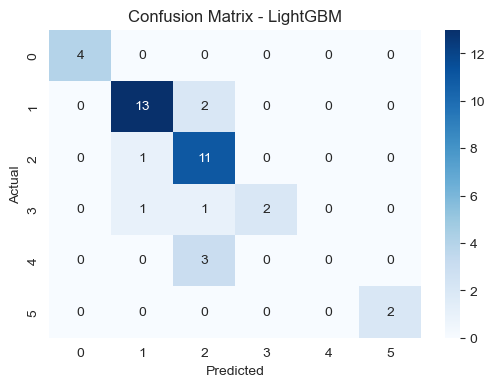

In [235]:
def evaluate_model(true_labels, predicted_labels, model_name):
    print(f"\n{model_name} Performance:")
    print("Accuracy:", accuracy_score(true_labels, predicted_labels))
    print("F1 Score:", f1_score(true_labels, predicted_labels, average='weighted'))
    print("AUC-ROC:", roc_auc_score(true_labels, predicted_labels, average='weighted', multi_class='ovo'))
    print("Classification Report:\n", classification_report(true_labels, predicted_labels, zero_division=0))

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(true_labels.argmax(axis=1), predicted_labels.argmax(axis=1)), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")
evaluate_model(y_test, y_pred_lgbm, "LightGBM")

# 8. Model Comparison


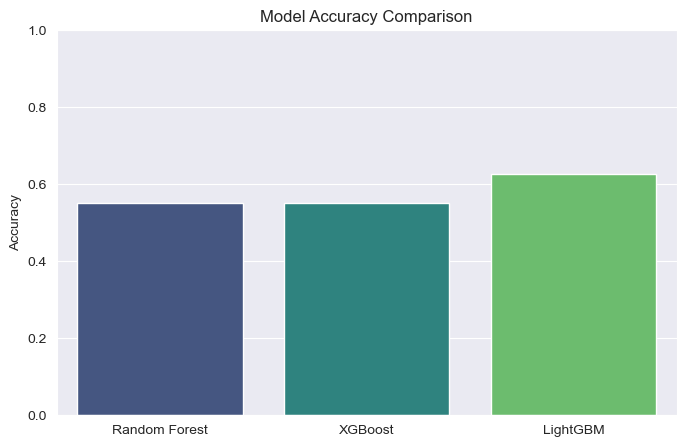

In [236]:
model_names = ["Random Forest", "XGBoost", "LightGBM"]
accuracies = [accuracy_score(y_test, y_pred_rf),
              accuracy_score(y_test, y_pred_xgb),
              accuracy_score(y_test, y_pred_lgbm)]

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=accuracies, hue=model_names, palette="viridis", dodge=False)
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.legend([], [], frameon=False)  # Hide legend
plt.show()